In [1352]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import(
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    f1_score, 
    precision_score, 
    recall_score, 
)
from typing import List

In [1353]:
training_data = pd.read_csv("Data/train.csv")
testing_data = pd.read_csv("Data/test.csv")

In [1354]:
# Split Passenger ID into Group number and position columns
training_data[["GroupNum", "GroupPosition"]] = (
    training_data
    .PassengerId
    .str
    .split("_", expand=True)
)

# Splitting Cabin into Deck, Room number, and side of ship 
training_data[["Deck", "RoomNum", "Side"]] = (
    training_data
    .Cabin
    .str
    .split("/", expand=True)
)

# Convert Data to proper types
training_data["GroupNum"] = training_data.GroupNum.astype('Int64')
training_data["GroupPosition"] = training_data.GroupPosition.astype('Int64')
training_data["RoomNum"] = training_data.RoomNum.astype('Int64')
training_data["CryoSleep"] = training_data.CryoSleep.astype(bool)
training_data["VIP"] = training_data.VIP.astype(bool)


# EDA

## Numerical Variables

In [1355]:
#Seperating Data into numerical columns then created a for loop to display the distribution of each column
numerical_variables = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col_name in numerical_variables:
    fig=px.histogram(
        training_data, 
        x=col_name, 
        title=f'Distribution of {col_name}'
    )
    fig.show()

## Categorical Variables

In [1356]:
def categorical_variable_survival_ratio(data_frame: pd.DataFrame, column_name:str, base:float=0) -> pd.DataFrame:
    # Calculate total amounnt for each value in column
    total_values = (
        data_frame[column_name]
        .value_counts()
        .reset_index()
        .rename(columns={'count':"total"})
    )

    # Calculate amount of of survivors and no-survivors for each value in column
    transported_values = (
        data_frame
        .groupby([column_name, "Transported"])
        .count()["PassengerId"]
        .reset_index()
        .rename(columns={'PassengerId':"amount"})
    )

    # Calculate survival ratio
    survival_rates = total_values.merge(transported_values)
    survival_rates["SurvivalRatio"] = survival_rates.amount / survival_rates.total

    # Pivot Table
    survival_rates = survival_rates.pivot(
        columns="Transported",
        index=column_name,
        values="SurvivalRatio"
    )

    return survival_rates - base

### Home Planet

In [1357]:
transported_proportion = 4378 / (4378 + 4315)

In [1358]:
training_data.HomePlanet.value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [1359]:
categorical_variable_survival_ratio(training_data, "HomePlanet", transported_proportion)

Transported,False,True
HomePlanet,,
Earth,0.072430,-0.079677
Europa,-0.162469,0.155222
Mars,-0.026648,0.019401


### CryoSleep

In [1360]:
training_data.CryoSleep.value_counts()

CryoSleep
False    5439
True     3254
Name: count, dtype: int64

In [1361]:
categorical_variable_survival_ratio(training_data, "CryoSleep", transported_proportion)

Transported,False,True
CryoSleep,,
False,0.167456,-0.174703
True,-0.299260,0.292013


### Destination

In [1362]:
training_data.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [1363]:
categorical_variable_survival_ratio(training_data, "Destination", transported_proportion)

Transported,False,True
Destination,,
55 Cancri e,-0.113624,0.106376
PSO J318.5-22,-0.007392,0.000145
TRAPPIST-1e,0.025201,-0.032449


### VIP

In [1364]:
training_data.VIP.value_counts()

VIP
False    8291
True      402
Name: count, dtype: int64

In [1365]:
categorical_variable_survival_ratio(training_data, "VIP", transported_proportion)

Transported,False,True
VIP,,
False,-0.009956,0.002709
True,0.048615,-0.055862


### GroupPosition

In [1366]:
training_data.GroupPosition.value_counts()

GroupPosition
1    6217
2    1412
3     571
4     231
5     128
6      75
7      46
8      13
Name: count, dtype: Int64

In [1367]:
categorical_variable_survival_ratio(training_data, "GroupPosition", transported_proportion)

Transported,False,True
GroupPosition,,
1,0.020423,-0.027671
2,-0.062405,0.055158
3,-0.121837,0.11459
4,-0.096697,0.08945
5,-0.050499,0.043251
6,-0.05029,0.043043
7,-0.003624,-0.003624
8,0.034838,-0.042085


### Deck

In [1368]:
training_data.Deck.value_counts()

Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

In [1369]:
categorical_variable_survival_ratio(training_data, "Deck", transported_proportion)

Transported,False,True
Deck,,
A,0.000283,-0.007530
B,-0.237898,0.230651
C,-0.183677,0.176430
D,0.063322,-0.070569
E,0.139070,-0.146318
F,0.056505,-0.063752
G,-0.019841,0.012594
T,0.296376,-0.303624


### Side

In [1370]:
training_data.Side.value_counts()

Side
S    4288
P    4206
Name: count, dtype: int64

In [1371]:
categorical_variable_survival_ratio(training_data, "Side", transported_proportion)

Transported,False,True
Side,,
P,0.045116,-0.052364
S,-0.058661,0.051414


### Age

In [1372]:
def group_ages(value):
    if value < 10:
        return "Toddler"
    elif value < 20:
        return "Teen"
    elif value < 30:
        return "Young Adult"
    elif value < 50:
        return "Adult"
    else:
        return "Senior"

In [1373]:
training_data["Age"] = training_data.Age.apply(group_ages)

In [1374]:
categorical_variable_survival_ratio(training_data, "Age", transported_proportion)

Transported,False,True
Age,,
Adult,0.019553,-0.026800
Senior,0.007488,-0.014735
Teen,-0.036416,0.029169
Toddler,-0.214964,0.207717
Young Adult,0.027151,-0.034398


### FoodCourt

In [1375]:
bin = 100
training_data["FoodCourt_binned"] = training_data.FoodCourt // bin * bin
categorical_variable_survival_ratio(training_data, "FoodCourt_binned",  transported_proportion)

Transported,False,True
FoodCourt_binned,,
0.0,-0.035937,0.028689
100.0,0.231671,-0.238918
200.0,0.260013,-0.267260
300.0,0.276037,-0.283285
400.0,0.248443,-0.255690
...,...,...
21000.0,NaN,0.496376
26800.0,NaN,0.496376
27000.0,NaN,0.496376


# Cleaning Data

In [1376]:
# Dropping Passenger ID, Cabin, and Name because they are unused
training_data = training_data.drop(columns=["PassengerId", "Cabin", "Name", "FoodCourt_binned"])

In [1377]:
training_data = pd.get_dummies(training_data)

In [1378]:
# Fill in nans with median for numerical values
for col_name in numerical_variables:
    if col_name != "Age":
        column_median = training_data[col_name].median()
        training_data[col_name] = training_data[col_name].fillna(column_median)

# Assign nan for RumNumber -1, a dummay value representing room unknown
training_data["RoomNum"] = training_data["RoomNum"].fillna(-1)

In [1379]:
training_data["TotalSpent"] = training_data.RoomService + training_data.FoodCourt + training_data.ShoppingMall + training_data.Spa + training_data.VRDeck

training_data = training_data.drop(columns=["Side_P", "GroupPosition"])

In [1380]:
group_spent = (
    training_data
    .groupby("GroupNum")
    .sum()["TotalSpent"]
    .reset_index()
    .rename(columns={"TotalSpent":"GroupSpent"})
)

training_data = training_data.merge(group_spent)

In [1381]:
training_data.corr()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNum,RoomNum,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,TotalSpent,GroupSpent
CryoSleep,1.000000,-0.050342,-0.240750,-0.202675,-0.207213,-0.196893,-0.190437,0.451744,-0.003709,-0.039476,...,0.121837,0.031703,-0.067703,-0.110477,-0.217772,0.237359,-0.008641,0.011838,-0.372437,-0.156760
VIP,-0.050342,1.000000,0.050354,0.088208,-0.000992,0.037896,0.087235,-0.024602,0.016651,-0.059427,...,0.034473,0.049751,0.043001,-0.019124,-0.035428,-0.062903,-0.005282,-0.003610,0.112384,0.083121
RoomService,-0.240750,0.050354,1.000000,-0.015126,0.052337,0.009244,-0.018624,-0.241124,0.000375,-0.012680,...,-0.064536,-0.019494,0.160699,0.043935,0.085627,-0.145289,0.007525,-0.014918,0.234374,0.108017
FoodCourt,-0.202675,0.088208,-0.015126,1.000000,-0.013717,0.221468,0.224572,0.045583,-0.009200,-0.177188,...,0.155351,0.257511,0.020128,-0.038889,-0.131988,-0.149911,0.014267,0.019625,0.742608,0.487887
ShoppingMall,-0.207213,-0.000992,0.052337,-0.013717,1.000000,0.014542,-0.007849,0.009391,0.017796,0.003533,...,-0.010750,0.000906,0.054823,0.031747,0.074473,-0.108538,-0.006787,-0.018018,0.220529,0.105585
Spa,-0.196893,0.037896,0.009244,0.221468,0.014542,1.000000,0.147658,-0.218545,-0.005198,-0.129223,...,0.114257,0.163670,0.033486,-0.011736,-0.087538,-0.124342,0.036316,-0.002116,0.592656,0.390685
VRDeck,-0.190437,0.087235,-0.018624,0.224572,-0.007849,0.147658,1.000000,-0.204874,0.015945,-0.133066,...,0.122644,0.206639,-0.003542,-0.017905,-0.094548,-0.127434,0.012369,-0.006950,0.585684,0.370692
Transported,0.451744,-0.024602,-0.241124,0.045583,0.009391,-0.218545,-0.204874,1.000000,0.021491,-0.043830,...,0.144733,0.108193,-0.034046,-0.097965,-0.087753,0.016269,-0.014568,0.101455,-0.199514,-0.025255
GroupNum,-0.003709,0.016651,0.000375,-0.009200,0.017796,-0.005198,0.015945,0.021491,1.000000,0.665595,...,-0.006284,0.012611,-0.008469,-0.000176,0.005232,0.001691,-0.016011,-0.002486,0.003012,0.003841
RoomNum,-0.039476,-0.059427,-0.012680,-0.177188,0.003533,-0.129223,-0.133066,-0.043830,0.665595,1.000000,...,-0.257561,-0.250361,-0.208524,-0.186881,0.452922,0.205108,-0.027310,-0.010549,-0.208837,-0.266049


# Fitting Model

In [1382]:
transported = training_data.Transported
training_data = training_data.drop(columns=["Transported"])

training_input, validation_input, training_output, validation_output = train_test_split(training_data, transported, test_size=0.25, random_state=69)

In [1383]:
training_input.columns

Index(['CryoSleep', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'GroupNum', 'RoomNum', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Age_Adult',
       'Age_Senior', 'Age_Teen', 'Age_Toddler', 'Age_Young Adult', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_S', 'TotalSpent', 'GroupSpent'],
      dtype='object')

In [1384]:
random_forest = RandomForestClassifier(
    n_estimators=400, 
    min_samples_leaf=25,
    max_features=5,
)
random_forest = random_forest.fit(training_input, training_output)

In [1385]:
def display_result_metrics(actual_labels:List[int], predicted_labels:List[int]) -> None:
    """Displays confusion matrix, accuracy, precision, recall, and f1-score given actual and predicted labels

    Args:
        actual_labels (List[int]): List containing the true label values
        predicted_labels (List[int]): List containing predicted label values
    """
    # Create confusion matrix
    cm_train = confusion_matrix(actual_labels, predicted_labels)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot()

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)
    precision = precision_score(actual_labels, predicted_labels)
    recall = recall_score(actual_labels, predicted_labels)
    f1 = f1_score(actual_labels, predicted_labels)
    
    # Display metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

Accuracy: 0.8206780181009358
Precision: 0.8188667872212176
Recall: 0.8270928462709285
F1 Score: 0.822959260941996


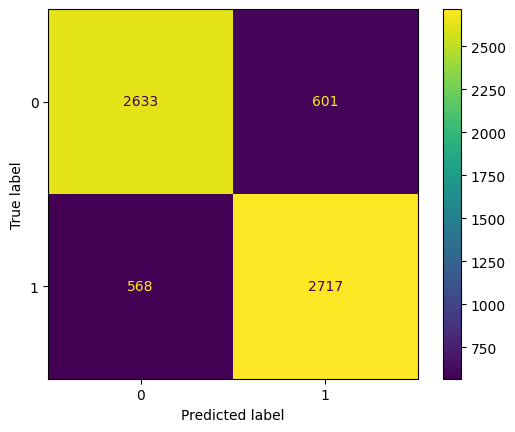

In [1386]:
training_predictions = random_forest.predict(training_input)
display_result_metrics(training_output, training_predictions)

Accuracy: 0.795768169273229
Precision: 0.7894736842105263
Recall: 0.8096980786825252
F1 Score: 0.7994579945799458


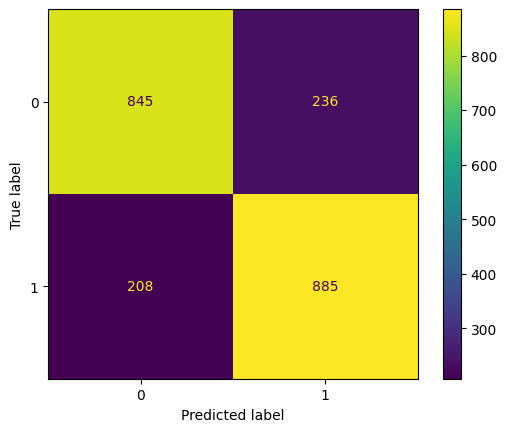

In [1387]:
validation_predictions = random_forest.predict(validation_input)
display_result_metrics(validation_output, validation_predictions)

In [1388]:
# from tqdm import tqdm

# validation_accurracy = 0
# best_estimator = 0

# for n_estimator in tqdm(range(1, 1000)):
#     random_forest = RandomForestClassifier(n_estimators=n_estimator)
#     random_forest = random_forest.fit(training_input, training_output)

#     validation_predictions = random_forest.predict(validation_input)
    
#     accuracy = accuracy_score(validation_output, validation_predictions)

#     if accuracy > validation_accurracy:
#         validation_accurracy = accuracy
#         best_estimator = n_estimator

# print(best_estimator, validation_accurracy)